In [33]:
import math

import numpy as np
import pandas as pd
import networkx as nx

import plotly.offline
import plotly.graph_objects as go

from sbemdb import SBEMDB
from cleandb import clean_db, clean_db_uct
from distance import distance

In [34]:
db = SBEMDB() # connect to DB
db = clean_db(db)

trees Before 398
trees After 46
nodes Before 37481
nodes After 16320
nodecons Before 73994
nodecons After 32548
syncons Before 1199
syncons After 826
synapses Before 552
synapses After 535


In [35]:
segments = pd.read_csv('segments_table.csv')
segments = segments[segments['type'] != 'main']
segments.head()

,segment_id,branch_id,type,depth,is_synapse,node_id,point_node_id
178,1,4851,root,1,False,4850,4850
179,1,4851,root,1,False,4851,4850
180,2,5589,root,1,False,4817,4817
181,2,5589,root,1,False,5589,4817
182,2,5589,root,1,False,5590,5589


In [36]:
x, y, z, nid = db.nodexyz()

coord_nid = {} # {(coords): nid}
nid_coord = {} # {nid: (coords)}
for i in range(len(x)):
    coord_nid[(x[i], y[i], z[i])] = nid[i]
    nid_coord[nid[i]] = (x[i], y[i], z[i])

In [37]:
x,y,z = db.segments(444)

G = nx.Graph() # graph of connected node ids given segments

for i in range(len(x) - 1):
    if not math.isnan(x[i]) and not math.isnan(x[i+1]):
        G_nid1 = coord_nid[(x[i], y[i], z[i])]
        G_nid2 = coord_nid[(x[i+1], y[i+1], z[i+1])]
        G.add_edge(G_nid1, G_nid2, distance=distance(x[i], y[i], z[i], x[i+1], y[i+1], z[i+1]))

In [38]:
segment_ids = segments['segment_id'].unique()

In [39]:
def get_length(segment_id):
    segment_nodes = segments[segments['segment_id'] == segment_id]
    start_node = segment_nodes.iloc[-1]['node_id']
    end_node = segment_nodes.iloc[0]['point_node_id']
    length = nx.dijkstra_path_length(G, start_node, end_node, 'distance')
    return length

segment_length = {segment_id: get_length(segment_id) for segment_id in segment_ids}

Code below is to find the neighbors.<br>
Where new segment starts (its node_id), the lower segments end (as its point_node_id).<br>
Consider:<br>
Segment 1:<br>
<b>node_id  point_node_id</b><br>
1 2<br>
2 3<br>
3 4<br>
<br>
Segment 2:<br>
<b>node_id  point_node_id</b><br>
4 5<br>
5 6<br>
...<br>
<br>
Segment 3:<br>
<b>node_id  point_node_id</b><br>
...<br>
13 14<br>
14 4<br>

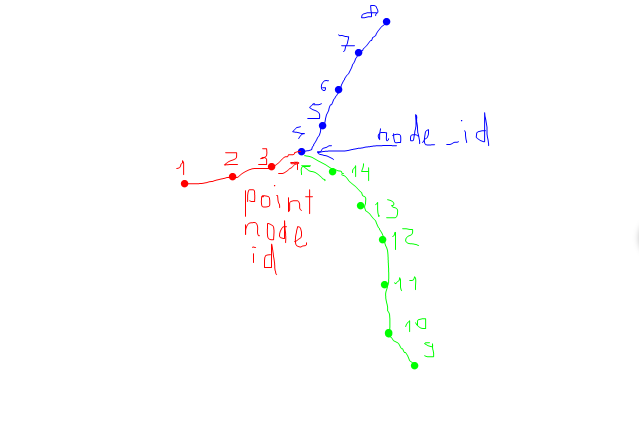

In [40]:
segment_neigh_lengths = {} # {segment_id: [its neighbors]}

for segment_id in segment_ids:
    segment_nodes = segments[segments['segment_id'] == segment_id]
    start_node = segment_nodes.iloc[-1]['node_id']
    end_node = segment_nodes.iloc[0]['point_node_id'] 
    
    segment_neigh_lengths[segment_id] = []
    for seg_id in segments[segments['point_node_id'] == start_node]['segment_id'].unique():
        # condition: find segments that contain the start_node in the point_node_id, start_node is unique
        if segment_id != seg_id: 
            segment_neigh_lengths[segment_id].append(seg_id) 
            
    for seg_id in segments[segments['point_node_id'] == end_node]['segment_id'].unique():
        # condition: find segments that contain the end_node in the point_node_id
        if segment_id != seg_id and seg_id not in segment_neigh_lengths[segment_id]: 
            segment_neigh_lengths[segment_id].append(seg_id) 
            
    for seg_id in segments[segments['node_id'] == end_node]['segment_id'].unique():
        # condition: find segments that contain the end_node in the node_id
        if segment_id != seg_id and seg_id not in segment_neigh_lengths[segment_id]:
            segment_neigh_lengths[segment_id].append(seg_id) 

In [41]:
x = []
y = []
texts = [] 

for x_segment_id, y_ids in segment_neigh_lengths.items():
    for y_segment_id in y_ids:
        x.append(segment_length[x_segment_id]) 
        y.append(segment_length[y_segment_id]) 
        texts.append(f'segments: {x_segment_id} and {y_segment_id}')
        
fig = go.Figure(data=go.Scatter(x=x, y=y, mode='markers', hovertext=texts))
fig.update_layout(
    autosize=False,
    width=500,
    height=500
)

In [42]:
fig = go.Figure(data=go.Scatter(x=y, y=x, mode='markers', hovertext=texts))
fig.update_layout(
    autosize=False,
    width=500,
    height=500
)
fig.show()